# Optimization II Project 3

In [23]:
import numpy as np
import gym
import tensorflow as tf
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, Input, MaxPool2D, MaxPool1D
from tensorflow import keras
from tqdm import tqdm

import matplotlib.pyplot as plt

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # stop displaying warnings that mean nothing!!!

PATH = ''

In [24]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit
# # %tensorboard --logdir=data/ --host localhost --port 8888

# Google Colab

In [25]:
# PATH = 'drive/MyDrive/MS/Opti/Project3/'

In [26]:
# from google.colab import drive
# drive.mount('/content/drive')

In [27]:
# !python -m atari_py.import_roms /content/drive/MyDrive/MS/Opti/Roms/

In [28]:
def prepro(I):
    I = I[::2,:,0].copy() # downsample by factor of 2
    dim = I.shape
    I = I.reshape(dim[0], dim[1])   # convert to a 2D array
    I = I[10:,::] # remove the top 7 rows of pixels : Score

    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    I = np.any( np.array(np.array_split(I, I.shape[1]//2, axis=1)) == 1, axis = 2).T
 
    return np.array(I)


def segment_env(I):
    '''
        segment the environment into 4 parts
        returns a list of 4 images
        Mothership, spawns, spaceship, lives, gun_heat
    '''
    I = I.copy()
    I = prepro(I)
    row_count, col_count = I.shape
    # Mothership
    I_mothership = I[:10, :]
    I_mothership = np.any(I_mothership == 1, axis=0).reshape(1, col_count)
    
    # Spawns
    I_spawns = I[10:row_count - 16, :]
    I_spawns = np.array([np.any(x == 1, axis=0) for x in np.array_split(I_spawns, I_spawns.shape[0]//2, axis=0)])

    # Spaceship
    I_spaceship = I[row_count-16:row_count-12, :]
    I_spaceship = np.any(I_spaceship == 1, axis=0).reshape(1, col_count)
    
    # Lets not bother about this now
    # Lives
    I_lives = I[row_count-10:row_count-5, :col_count//2]
    I_lives = np.any(I_lives == 1, axis=0).reshape(1, col_count//2)
    split = np.array(np.array_split(I_lives[:, 4:], 4, axis = 1))
    num_lives = np.any(split == 1, axis = 2).sum() + 1
    # print('Num Lives',num_lives)
    
    # gun_heat
    I_gun_heat = I[row_count-10:row_count-5, col_count//2:]
    I_gun_heat = np.any(I_gun_heat == 1, axis=0).reshape(1, col_count//2)
    
    heat_gun_padding = 8
    percent_heat = I_gun_heat[:, heat_gun_padding:].sum() / I_gun_heat[:, heat_gun_padding:].shape[1]
    # print('Percent Heat', percent_heat)

    I_health = np.concatenate((I_lives, I_gun_heat), axis=1)

    segment_list = [I_mothership, I_spawns, I_spaceship]#, I_health]
    # return segment_list
    return np.concatenate(segment_list, axis=0), num_lives, percent_heat


In [29]:

def plot_environment(I):
    fig, ax = plt.subplots(1, 2, figsize=(20, 20), sharex= False, sharey= False)
    ax[0].imshow(I)

    prep_im, _, _ = segment_env(I)
    ax[1].imshow(prep_im, cmap='gray')
    plt.show()

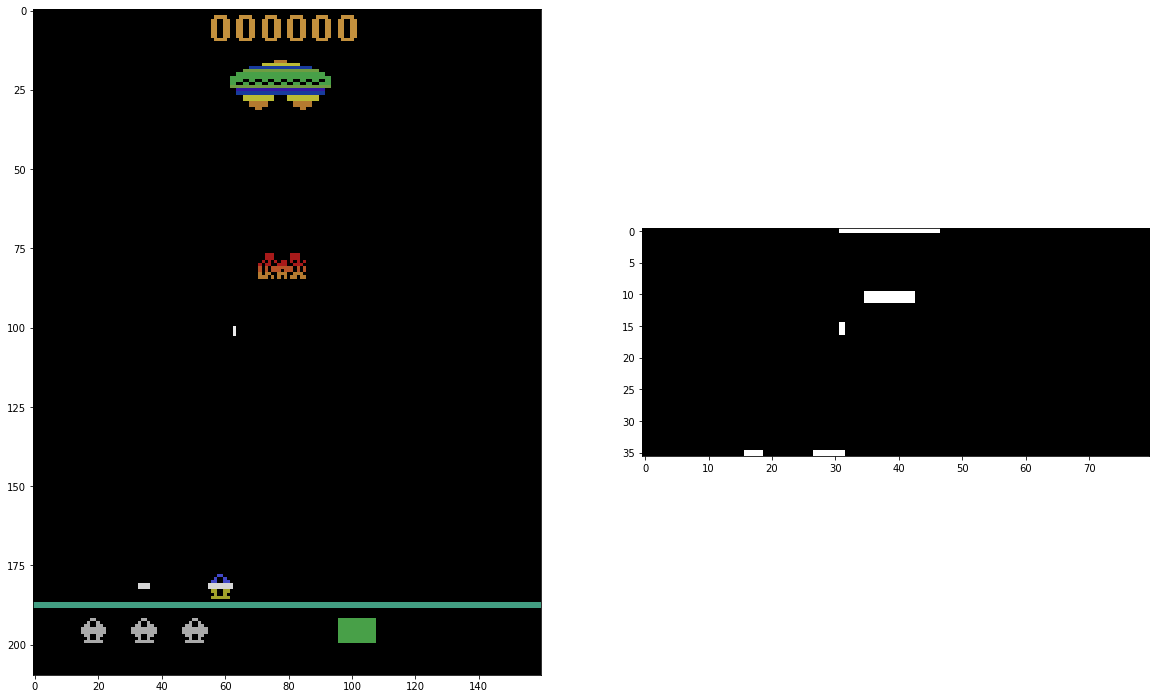

(36, 80)
['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


In [30]:
frames_to_net = 1
frames_this_game = 0

env = gym.make("Assault-v0")

pix = env.reset()
for i in range(15):
    pix, reward, done, info = env.step(env.action_space.sample()) # take a random action

board_dimensions = segment_env(pix)[0].shape

plot_environment(pix)

env.reset()
env.close()

print(board_dimensions)

action_space = env.action_space.n
print(env.unwrapped.get_action_meanings())
del env

### Policy Gradient with linear annealing, memory buffer, and same action for 4 consecutive frames

In [31]:
def discount_rewards(r):
    # take 1D float array of rewards and compute discounted reward
    # gym returns a reward with every single frame.  most of those rewards are 0
    # sometimes they're 1 or -1 if we win or lose a point in that specific frame
    # we want non-0 rewards for every frame. 
    # so take each frame, figure out if we eventually won the corresponding point or not
    # if so make the reward positive, if not negative
    # but more recent actions (relative to the frame where the point is awarded) are more 
    # impactful to the score that frames a long time ago, so discount rewards...
    
    delt = 0.99 # discount factor
    nr = len(r)
    # we want to change all those zeros into discounted values of the next reward (this is the value function!)
    discounted_r = [0.0]*nr
    
    for t in range(nr):
        # start at the end
        if r[nr-t-1] > 0: # if you won a point in this frame we want a good reward
            discounted_r[nr-t-1] = 1
        elif r[nr-t-1] < 0: # if we lost the point we want a bad reward
            discounted_r[nr-t-1] = -1
        elif t==0: # this is just for error catching...at t==0 r[nr-t-1] should have already been + or -...
            discounted_r[nr-t-1] = 0
        elif discounted_r[nr-t-1] == 0: # otherwise you want to look at the next reward value and discount it
            discounted_r[nr-t-1] = delt*discounted_r[nr-t]
    return discounted_r

In [32]:
frames_to_net = 4              # how many previous frames will we feed the NN
possible_actions = [x for x in range(5)] # the possible actions we can take

# Training the NN

In [65]:
model_name = 'assault_final'

In [66]:
# mod = tf.keras.models.load_model(PATH+f'{model_name}.tf')
mod = tf.keras.models.load_model(PATH+f'../weights/{model_name}.h5')
# mod.call = tf.function(mod.call,experimental_relax_shapes=True)

mod.summary()

model_name = 'assault_final_lives_penalty'

Model: "dual_input_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board_input (InputLayer)       [(None, 36, 80, 4)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 17, 39, 32)   2080        ['board_input[0][0]']            
                                                                                                  
 health_input (InputLayer)      [(None, 1, 2, 4)]    0           []                               
                                                                                                  
 conv2 (Conv2D)                 (None, 4, 9, 16)     12816       ['conv1[0][0]']                  
                                                                                   

In [70]:
x = mod.layers[-2].output
predictions = tf.keras.layers.Dense(7, activation='softmax', name = 'output')(x)
mod = Model(mod.input, predictions)
mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),loss='sparse_categorical_crossentropy')
mod.call = tf.function(mod.call,experimental_relax_shapes=True)

mod.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board_input (InputLayer)       [(None, 36, 80, 4)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 17, 39, 32)   2080        ['board_input[0][0]']            
                                                                                                  
 health_input (InputLayer)      [(None, 1, 2, 4)]    0           []                               
                                                                                                  
 conv2 (Conv2D)                 (None, 4, 9, 16)     12816       ['conv1[0][0]']                  
                                                                                            

## Play the game

In [71]:
def play1game(model, ep = 0, render=False, slow= 0.01):
    env0 = gym.make("Assault-v0")
    pix = env0.reset()
    pix, num_lives, percent_heat = segment_env(pix)

    num_bombs = -1 # at least 1 object in this line...my bot
    for i in range(1,pix.shape[1],3):
        if pix[-1,i] == 1 and pix[-1,i-1] == 1:
            num_bombs += 1
    
    health = np.array([num_lives, percent_heat]).reshape((1,2))
    dimensions = pix.shape

    action_space = env0.unwrapped.action_space.n# the -2 is because we don't want to fire left or right
    
    frames_this_game = 0
    feed = np.zeros((1, dimensions[0], dimensions[1],frames_to_net))
    feed[0,:,:,0] = pix.copy()
    
    health_feed = np.zeros((1,1,2, frames_to_net))
    health_feed[0,:,:,0] = health.copy()
    
    prev_num_lives = 0
    frame_array = []
    health_array = []
    action_array = []
    reward_array = []
    
    score = 0
    action = 0
    done = False
    try:
        while not done:
            if render == True: # do you actually want to visualize the playing?
                env0.render()
                time.sleep(slow)
            
            # skipping every 4 frames
            if frames_this_game%4 == 0:
                vf = model([feed, health_feed ],training=False).numpy()[0]
                    # epsilon-greedy
                if np.random.random() < ep:
                    action = np.random.choice(action_space)
                else:
                    action = np.random.choice(action_space,p=vf)
            
            pix_new, reward, done, info = env0.step(action)
            pix, num_lives, percent_heat = segment_env(pix_new)

            # Penalty for losing a life
            if num_lives < prev_num_lives:
                reward = -1
            prev_num_lives = num_lives

            health = np.array([num_lives, percent_heat]).reshape((1,2))

            frame_array.append(pix)
            action_array.append(action)
            reward_array.append(reward)
            health_array.append(health)
            frames_this_game += 1

            for f in range(1,frames_to_net):
                feed[0,:,:,frames_to_net-f] = feed[0,:,:,frames_to_net-f-1].copy()
            feed[0,:,:,0] = pix.copy()
            score += reward

            if frames_this_game > 50000:#5000000:
                print("Game is taking too long, breaking")
                done = True
                break
    
    except Exception as e:
        print(e)
    except KeyboardInterrupt:
        print('KeyboardInterrupt')
    finally:
        env0.reset()
        env0.close()
        
    return frame_array, health_array, action_array, reward_array, score

In [72]:
# tgames = 10000 # training games
tgames = 500
epsvec = np.linspace(1,0.05,tgames)
ngames = 200 # games played after training
nbatch = 10
buffn = 200000
warmupgames = 5
len_buff = 0
buffer = {'frames':[], 'healths':[],'actions':[],'rewards':[]}

In [73]:
game = 0
scores = []

In [74]:
model_name

'assault_final_lives_penalty'

In [75]:
import sys
pbar = tqdm(total=tgames)

with open(PATH+f'scores_{model_name}.csv','a') as out_file:
    # out_file.write('game,score, train_time, len_buff, timestamp\n')

    while True:
        pbar.update(1)
        start = time.time()
        g = min(game, tgames-1)
        frames, healths, actions, rewards, score = play1game(mod, epsvec[g])

        rewards = discount_rewards(rewards.copy())
        # memory buffer
        buffer['frames'] += frames.copy()
        buffer['healths'] += healths.copy()
        buffer['actions'] += actions.copy()
        buffer['rewards'] += rewards.copy()
        len_buff += len(actions)

        if len_buff > buffn:
            excess = len_buff - buffn
            buffer['frames'] = buffer['frames'][excess:].copy()
            buffer['healths'] = buffer['healths'][excess:].copy()
            buffer['actions'] = buffer['actions'][excess:].copy()
            buffer['rewards'] = buffer['rewards'][excess:].copy()
            len_buff = len(buffer['actions'])
        rewards = np.array(rewards)
        actions = np.array(actions)
        nframes = len(frames)

        current_frames = np.zeros((nframes, board_dimensions[0], board_dimensions[1],frames_to_net))
        current_health = np.zeros((nframes, 1, 2, frames_to_net))
        
        if game >= warmupgames:
            prob = np.ones(len_buff)
            prob[np.array(buffer['rewards']) > 0] = 5.0
            
            prob /= np.sum(prob)
            which_choose = np.random.choice(len_buff,size=nframes,replace=False,p=prob)
        
            for grab in range(nframes):
                rewards[grab] = buffer['rewards'][which_choose[grab]]
                actions[grab] = buffer['actions'][which_choose[grab]]
                for f in range(frames_to_net):
                    if grab-f > 0:
                        current_frames[grab,:,:,f] = buffer['frames'][which_choose[grab]-f].copy()
                        current_health[grab,:,:,f] = buffer['healths'][which_choose[grab]-f].copy()
            
            history = mod.fit([current_frames, current_health],actions,epochs=1,steps_per_epoch=nbatch,verbose=0,sample_weight=rewards,use_multiprocessing=True)
        stop = time.time()
        
        game += 1
        # too many games to train on, hard stop
        if game >= tgames:
            break
        # append consecutive positive scores
        if score > 0:
            scores.append(score)
        elif len(scores) > 0:
            scores.pop(0)
        else:
            pass
        t = time.localtime()
        out_file.write(str(game)+','+str(score)+','+str(round(stop-start, 4))+','+str(len_buff)+'\n')
        out_file.flush()


        mod.save(PATH+f'weights/{model_name}.h5')
        
        if (game)%100 == 1:
          time.sleep(0.01) # allow changes to reflect on drive
        sys.stdout.flush()
        if len(scores) > tgames:
            break

  2%|▏         | 10/500 [33:22<27:15:07, 200.22s/it]


KeyboardInterrupt: 

# Visualise the game after training

In [76]:
# model_name = 'assault_v2_background_e10000'

# mod2 = tf.keras.models.load_model(PATH+f'{model_name}.tf')
mod2 = tf.keras.models.load_model(PATH+f'weights/{model_name}.h5')
mod2.call = tf.function(mod2.call,experimental_relax_shapes=True)

mod2.summary()

Model: "dual_input_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board_input (InputLayer)       [(None, 36, 80, 4)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 17, 39, 32)   2080        ['board_input[0][0]']            
                                                                                                  
 health_input (InputLayer)      [(None, 1, 2, 4)]    0           []                               
                                                                                                  
 conv2 (Conv2D)                 (None, 4, 9, 16)     12816       ['conv1[0][0]']                  
                                                                                   

In [13]:
frame_array, health_array, action_array, reward_array, score = play1game(mod2, 0, slow= 0.01)

plt.imshow(frame_array[-1])
print(score)

NameError: name 'play1game' is not defined

In [ ]:
ngames = 100
scores = np.zeros(ngames)
for game in tqdm(range(ngames)):
    frames, health, actions, rewards, score = play1game(mod2, 0)
    scores[game] = score

np.mean(scores)